# Stack Overflow Data: A Blog Post

The data that will be analyzed in this notebook originate from a massive survey of stack overflow users, where different topics are asked, such as knowledge, income, geographic information, labor information, and other topics that allow for a detailed descriptive analysis of the population. who answered the survey.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import janitor
import sklearn as sk
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [21]:
df = pd.read_csv('.\\survey_results_public.csv')

## Business Understanding

Perhaps one of the most discussed issues today is the level of knowledge, the sources where that knowledge is obtained and whether the type of education makes any difference to the salary or income of someone who works in the field of software development. or in fields close to it.

Therefore, different questions are posed with the intention of obtaining the necessary information to answer them at the end of this notebook.

1. Does being doctor improve the salary?
2. Is there a difference between proffessional developers who are self-taught and those who learn in other ways in the Salarys?
3. When a worker prefers the benefits of remote work, does the salary increase?

## Data Understanding
Number of variables with a proportion of nulls greater than 80%, are considered irrelevant variables and are eliminated in this study.

In [22]:
nulls_df = pd.DataFrame((df.isnull().sum() / len(df)),
                        columns = ['Nulls']).sort_values(by = 'Nulls', ascending = False)
columnas_drop = list(nulls_df[nulls_df['Nulls'] > 0.8].reset_index()['index'])
print('Number of variables with nulls above 80%: -----> ',len(columnas_drop))
df.drop(columnas_drop, axis = 1, inplace = True)

Number of variables with nulls above 80%: ----->  13


In [23]:
print('::::There are more categorical variables than numerical variables::::')
df.info()

::::There are more categorical variables than numerical variables::::
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51392 entries, 0 to 51391
Columns: 141 entries, Respondent to Salary
dtypes: float64(5), int64(1), object(135)
memory usage: 55.3+ MB


In [24]:
print('Respondent Variable is just a primary key')
df.select_dtypes(exclude = 'object')

Respondent Variable is just a primary key


,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary
0,1,NaN,NaN,0.0,9.0,NaN
1,2,NaN,NaN,NaN,8.0,NaN
2,3,8.0,9.0,NaN,8.0,113750.0
3,4,6.0,3.0,5.0,10.0,NaN
4,5,6.0,8.0,NaN,NaN,NaN
...,...,...,...,...,...,...
51387,51388,7.0,3.0,5.0,9.0,58000.0
51388,51389,NaN,NaN,NaN,7.0,NaN
51389,51390,10.0,10.0,NaN,NaN,NaN
51390,51391,6.0,7.0,1.0,9.0,40000.0


In [25]:
df.drop(['Respondent'],axis= 1, inplace = True)

In [26]:
(
    df
    .select_dtypes(exclude = 'object')
    .describe()
)

,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary
count,42695.000000,40376.000000,20600.000000,36592.000000,12891.000000
mean,7.300574,6.957078,3.952282,8.429875,56298.480641
std,1.955444,2.167652,7.564722,1.390635,39880.905277
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,6.000000,1.000000,8.000000,26440.371839
50%,8.000000,7.000000,1.000000,9.000000,50000.000000
75%,9.000000,8.000000,4.000000,10.000000,80000.000000
max,10.000000,10.000000,40.000000,10.000000,197000.000000


The salary variable is the one with the most presence of nulls, to continue with the analysis of the salary with respect to the other variables, it should be considered to keep only the records that contain salary information.

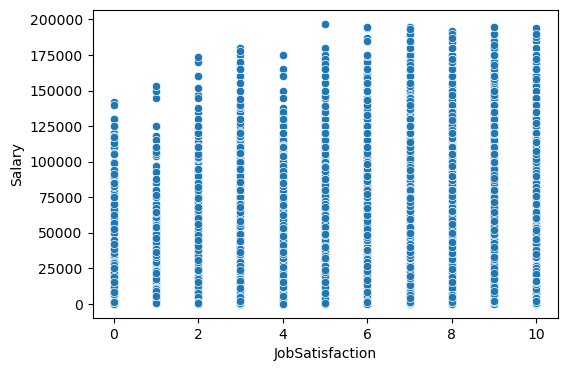

In [31]:
plt.subplots(figsize = (6,4))
sns.scatterplot(data = df,
               x = 'JobSatisfaction',
               y = 'Salary')
plt.show()

It seems that there is a concentration of slightly lower income in ratings close to zero.

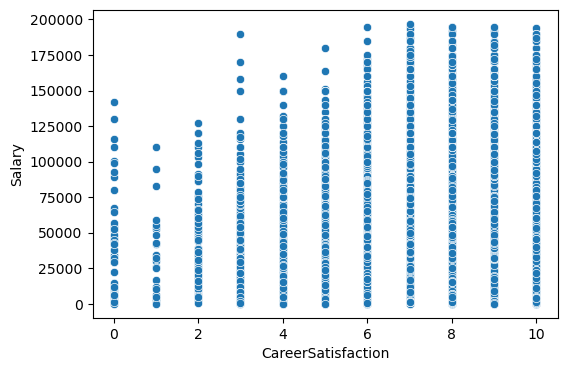

In [32]:
plt.subplots(figsize = (6,4))
sns.scatterplot(data = df,
               x = 'CareerSatisfaction',
               y = 'Salary')
plt.show()

Same as above one, it seems that there is a concentration of slightly lower income in ratings close to zero.

In [39]:
columnas = ['Salary','JobSatisfaction','CareerSatisfaction','HoursPerWeek',
            'StackOverflowSatisfaction','HaveWorkedLanguage',
            'Currency','Methodology','EducationTypes','ImportantBenefits',
            'LearningNewTech','Gender','YearsProgram','MajorUndergrad',
            'Country','University','EmploymentStatus','FormalEducation',
            'Professional','ProgramHobby']
pd.DataFrame((df[columnas].isnull().sum() / len(df)), columns = ['Nulls_prop']).sort_values(by = 'Nulls_prop', ascending = False)

,Nulls_prop
Salary,0.749163
HoursPerWeek,0.599159
Currency,0.583437
Methodology,0.498541
ImportantBenefits,0.411679
EducationTypes,0.409363
LearningNewTech,0.390878
Gender,0.318046
StackOverflowSatisfaction,0.287983
HaveWorkedLanguage,0.287340


A group of variables that were considered important for the analysis of the salary of the respondents was chosen, half of these variables present null values ​​which will be imputed in the next section.

In [40]:
df_f = df[columnas].copy(deep = True)

#### Exploratory Data Analysis

In [41]:
pd.crosstab(index=df_f['Professional'],
            columns=df_f['EmploymentStatus'], 
            margins=True).sort_values(by = 'All')

EmploymentStatus,Employed full-time,Employed part-time,I prefer not to say,"Independent contractor, freelancer, or self-employed","Not employed, and not looking for work","Not employed, but looking for work",Retired,All
Professional,,,,,,,,
None of these,278,72,90,120,219,115,20,914
Used to be a professional developer,580,41,14,116,53,97,82,983
Professional non-developer who sometimes writes code,3815,388,86,559,86,190,16,5140
Student,1264,1255,704,747,2310,1919,25,8224
Professional developer,30211,1424,192,3691,123,465,25,36131
All,36148,3180,1086,5233,2791,2786,168,51392


More respondents are professional developers and full-time employees, followed by independent students and job seekers.

In [42]:
pd.crosstab(index=df_f['FormalEducation'],
            columns=df_f['EmploymentStatus'], 
            margins=True).sort_values(by = 'All')

EmploymentStatus,Employed full-time,Employed part-time,I prefer not to say,"Independent contractor, freelancer, or self-employed","Not employed, and not looking for work","Not employed, but looking for work",Retired,All
FormalEducation,,,,,,,,
I never completed any formal education,232,18,21,67,56,23,9,426
Professional degree,533,33,10,91,11,28,9,715
Primary/elementary school,162,82,75,129,482,107,10,1047
I prefer not to answer,314,60,355,122,182,68,8,1109
Doctoral degree,1103,35,13,109,10,16,22,1308
Secondary school,2121,784,260,747,1215,770,11,5908
Some college/university study without earning a bachelor's degree,5184,790,109,1051,381,584,30,8129
Master's degree,9206,338,76,1099,98,291,33,11141
Bachelor's degree,17293,1040,167,1818,356,899,36,21609


The majority of full-time employees are Bachelor's degree, followed by master's degree graduates. On the other hand, independent or freelancers are more concentrated in high school degrees, which is related if the previous table is analyzed, where they are mostly students.

In [43]:
pd.crosstab(index=df_f['FormalEducation'],
            columns=df_f['Professional'], 
            margins=True).sort_values(by = 'All')

Professional,None of these,Professional developer,Professional non-developer who sometimes writes code,Student,Used to be a professional developer,All
FormalEducation,,,,,,
I never completed any formal education,28,261,36,91,10,426
Professional degree,13,543,83,59,17,715
Primary/elementary school,115,204,58,660,10,1047
I prefer not to answer,80,389,79,545,16,1109
Doctoral degree,39,791,395,38,45,1308
Secondary school,194,2280,415,2971,48,5908
Some college/university study without earning a bachelor's degree,140,5390,821,1634,144,8129
Master's degree,102,8983,1323,432,301,11141
Bachelor's degree,203,17290,1930,1794,392,21609


Most professional developers are Bachelor's degree followed by Master's degree

In [44]:
def plotting_kden(df, x, hue,title):
    sns.kdeplot(data = df,
             x = x,
             hue = hue).set(title = title)
    plt.grid(axis = 'y', alpha = 0.75)
    plt.show()

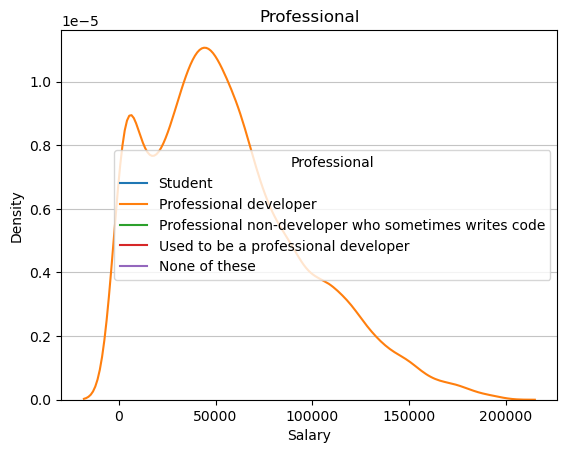

In [61]:
plotting_kden(df_f,
              x = 'Salary',
              hue = 'Professional',
              title = 'Professional')

The professional rank only presents salary information for current professional developers, so this category is irrelevant to the salary rank.

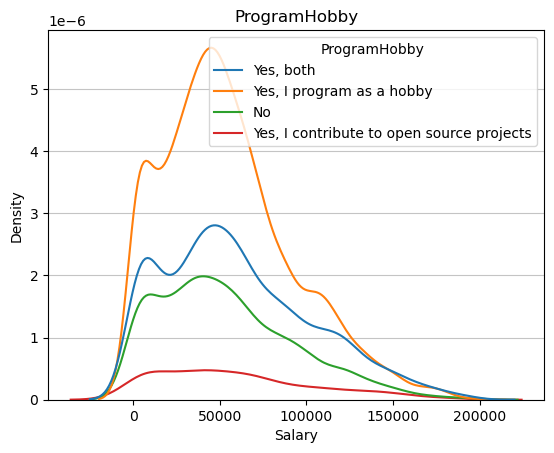

In [63]:
plotting_kden(df_f,
              x = 'Salary',
              hue = 'ProgramHobby',
              title = 'ProgramHobby')

In [103]:
df_f.groupby('ProgramHobby').agg(np.mean).reset_index()[['ProgramHobby','Salary']].sort_values(by = 'Salary')

C:\Users\FRLUENGA\AppData\Local\Temp\ipykernel_16576\1582266120.py:1: FutureWarning: The operation <function mean at 0x0000015D2F970820> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_f.groupby('ProgramHobby').agg(np.mean).reset_index()[['ProgramHobby','Salary']].sort_values(by = 'Salary')


,ProgramHobby,Salary
0,No,53915.095919
2,"Yes, I program as a hobby",54563.652661
1,"Yes, I contribute to open source projects",59019.558827
3,"Yes, both",60479.138605


There is a difference in salaries between people who code as a hobby and those who do not. When the respondent programs as a hobby and contributes to open source projects, he has an average salary of 60479, while if he does neither, he has an average salary of 53915.

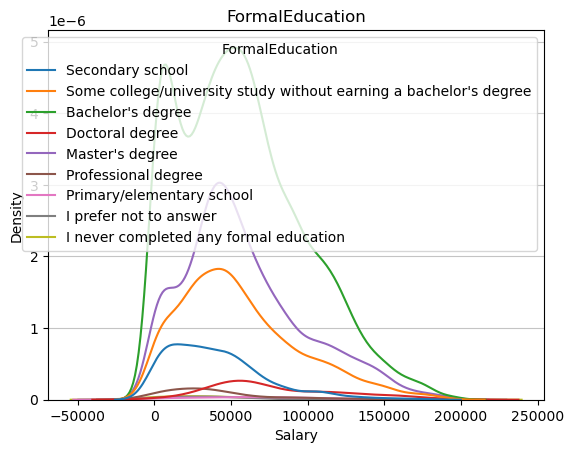

In [64]:
plotting_kden(df_f,
              x = 'Salary',
              hue = 'FormalEducation',
              title = 'FormalEducation')

In [85]:
df_f.groupby('FormalEducation').agg(np.mean).reset_index()[['FormalEducation','Salary']].sort_values(by = 'Salary')

C:\Users\FRLUENGA\AppData\Local\Temp\ipykernel_16576\3023262603.py:1: FutureWarning: The operation <function mean at 0x0000015D2F970820> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_f.groupby('FormalEducation').agg(np.mean).reset_index()[['FormalEducation','Salary']].sort_values(by = 'Salary')


,FormalEducation,Salary
3,I prefer not to answer,38284.836141
6,Professional degree,39503.658863
7,Secondary school,40395.148419
2,I never completed any formal education,44430.660621
8,Some college/university study without earning ...,55912.810459
0,Bachelor's degree,56914.358553
4,Master's degree,58250.838766
5,Primary/elementary school,62677.337356
1,Doctoral degree,78527.933053


Having a doctorate indicates that on average you will have a salary of 78527, higher than the other types of education, even higher than the Bachelor's degree.

In [55]:
# Grouping the variable years programming into fewer categories in order to visualize it better
df_f['YearsProgramNew'] = df_f['YearsProgram'].replace({
'Less than a year': 'less than 2 years',
'1 to 2 years': 'less than 2 years',
'2 to 3 years': 'less than 7 years',
'3 to 4 years': 'less than 7 years',
'4 to 5 years': 'less than 7 years',
'5 to 6 years': 'less than 7 years',
'6 to 7 years': 'less than 7 years',
'7 to 8 years': 'less than 12 years',
'8 to 9 years': 'less than 12 years',
'9 to 10 years': 'less than 12 years',
'10 to 11 years': 'less than 12 years',
'11 to 12 years' : 'less than 12 years',
'12 to 13 years': 'less than 17 years',
'13 to 14 years': 'less than 17 years',
'14 to 15 years': 'less than 17 years',
'15 to 16 years': 'less than 17 years',
'16 to 17 years': 'less than 17 years',
'17 to 18 years': 'less than 20 years',
'18 to 19 years': 'less than 20 years',
'19 to 20 years': 'less than 20 years',
'20 or more years':  '20 or more years'
})

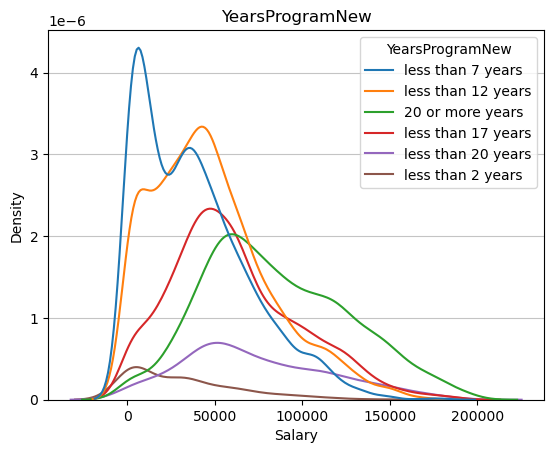

In [65]:
plotting_kden(df_f,
              x = 'Salary',
              hue = 'YearsProgramNew',
              title = 'YearsProgramNew')

In [84]:
df_f.groupby('YearsProgramNew').agg(np.mean).reset_index()[['YearsProgramNew','Salary']]

C:\Users\FRLUENGA\AppData\Local\Temp\ipykernel_16576\1651987123.py:1: FutureWarning: The operation <function mean at 0x0000015D2F970820> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_f.groupby('YearsProgramNew').agg(np.mean).reset_index()[['YearsProgramNew','Salary']]


,YearsProgramNew,Salary
0,20 or more years,84564.967771
1,less than 12 years,47668.490034
2,less than 17 years,60880.860565
3,less than 2 years,31729.385835
4,less than 20 years,73076.328103
5,less than 7 years,38029.905012


The probability distributions of salaries seem directly proportional to the number of years programming, that is, the more years programming, the higher the income. 

The difference in salaries is quite large between those who program for more than 20 years and those who are just starting to program. While the average salary of those who have been programming for more years is 84564, those who are just starting out have an average salary of 31729.

In [66]:
pd.DataFrame(df_f['EducationTypes'].value_counts()).sort_values(by='EducationTypes',ascending = False).head(10)

,EducationTypes
Self-taught,3691
Online course; Self-taught,1875
Self-taught; Open source contributions,1751
On-the-job training; Self-taught,1687
Online course; On-the-job training; Self-taught,1276
Online course; Self-taught; Open source contributions,856
On-the-job training; Self-taught; Open source contributions,780
Self-taught; Hackathon; Open source contributions,521
Online course; On-the-job training; Self-taught; Open source contributions,496
Online course; Self-taught; Coding competition,479


There is a high presence of self-taught in the type of education, which makes it interesting to analyze their income level

In [67]:
pd.DataFrame(df_f['ImportantBenefits'].value_counts()).sort_values(by='ImportantBenefits',ascending = False).head(10)

,ImportantBenefits
None of these,653
Retirement; Vacation/days off; Health benefits; Expected work hours; Remote options,363
Vacation/days off; Equipment; Professional development sponsorship; Expected work hours; Remote options,324
Vacation/days off; Health benefits; Equipment; Expected work hours; Remote options,305
Vacation/days off; Health benefits; Professional development sponsorship; Expected work hours; Remote options,249
Annual bonus; Vacation/days off; Health benefits; Expected work hours; Remote options,209
Remote options,197
Vacation/days off; Expected work hours; Remote options,182
Vacation/days off; Health benefits; Equipment; Professional development sponsorship; Remote options,179
Retirement; Annual bonus; Vacation/days off; Health benefits; Remote options,178


For some respondents, the importance of having a remote work benefit is high, so a variable is created from that benefit to compare it with the salary level.

In [73]:
# Create a variable to identify PhD holders
doctoral = df_f[(df_f['FormalEducation'] == 'Doctoral degree') & (~df_f['Salary'].isnull())]
non_doctoral = df_f[(df_f['FormalEducation'] != 'Doctoral degree') & 
                    (~df_f['Salary'].isnull()) &
                    (~df_f['FormalEducation'].isnull())                   
                   ]

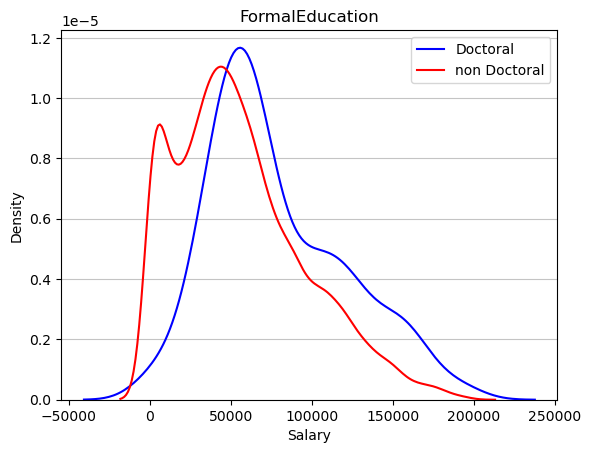

In [74]:
sns.kdeplot( data = doctoral,
             x = 'Salary' ,
             color = 'blue',
             label = "Doctoral").set(title='FormalEducation')

sns.kdeplot( data = non_doctoral,
             x = 'Salary' ,
             color = 'red',
             label="non Doctoral")

# plt.xlim(p15,p85)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [105]:
print('The average salary for those who have Doctoral is : ',doctoral.Salary.mean())
print('The average salary for those who have not Doctoral is : ',non_doctoral.Salary.mean())

The average salary for those who have Doctoral is :  78527.93305324153
The average salary for those who have not Doctoral is :  55781.475595630414


there is a difference between the respondents with a doctorate and without a doctorate in terms of salary, this difference is conclusive to affirm that the salary is higher than the respondent who has a doctorate. also it suggest that the salary of respondent who has a doctorate is unlikely lower.

The average salary for those with a PhD is 78527, while those without a PhD is 55781.



In [75]:
# create a variable to identify self-taught from non-self-taught
df_f['Self-taught'] = df_f['EducationTypes'].apply(lambda x: 'Self-taught' if 'Self-taught' in str(x) else 'other')

In [76]:
self_taught = df_f[(df_f['Self-taught'] == 'Self-taught') & 
                   (~df_f['Salary'].isnull()) ]

non_self_taught = df_f[
                        (df_f['Self-taught'] == 'other') & 
                       (~df_f['Salary'].isnull()) &
                       (~df_f['EducationTypes'].isnull())
                      ]

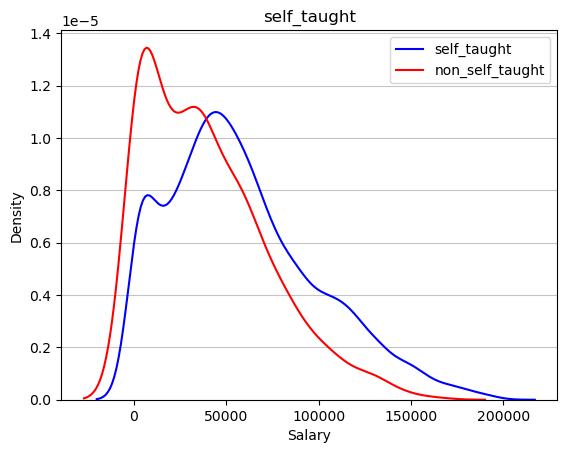

In [77]:
p15,p85 = np.percentile(df['JobSatisfaction'],[2.5, 97.5])

sns.kdeplot( data = self_taught,
             x = 'Salary' ,
             color = 'blue',
             label = "self_taught").set(title='self_taught')

sns.kdeplot( data = non_self_taught,
             x = 'Salary' ,
             color = 'red',
             label="non_self_taught")

# plt.xlim(p15,p85)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [90]:
print('The average salary for those who were self-taught is : ',self_taught.Salary.mean())
print('The average salary for those who were not self-taught is : ',non_self_taught.Salary.mean())

The average salary for those who were self-taught is :  58531.526886201675
The average salary for those who were not self-taught is :  39286.09587289545


people who are self-taught have bigger salary than who are not self-taught, probability distributions suggest that is likely you have a big salary if you was self-taught.

On average, those who were self-taught have a salary of 58531, while those who were not have a salary of 39286.

In [78]:
# Create a variable that indicates those who consider remote work important
df_f['remote'] = df_f['ImportantBenefits'].apply(lambda x: 'Remote' if 'Remote options' in str(x) else 'other')

In [79]:
remote = df_f[(df_f['remote'] == 'Remote') & (~df_f['JobSatisfaction'].isnull())]
non_remote = df_f[(df_f['remote'] == 'other') & (~df_f['JobSatisfaction'].isnull()) &
                    (~df_f['ImportantBenefits'].isnull())
                   ]

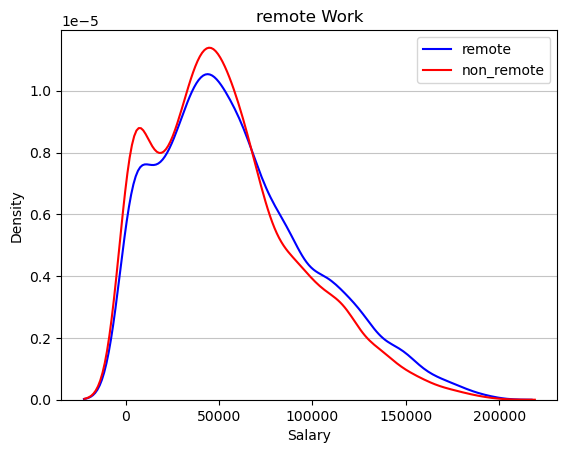

In [80]:

sns.kdeplot( data = remote,
             x = 'Salary' ,
             color = 'blue',
             label = "remote").set(title='remote Work')

sns.kdeplot( data = non_remote,
             x = 'Salary' ,
             color = 'red',
             label="non_remote")

# plt.xlim(p15,p85)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [89]:
print('The average salary for those who prefer remote work is : ',remote.Salary.mean())
print('The average salary for those who do not prefer remote work is : ',non_remote.Salary.mean())

The average salary for those who prefer remote work is :  59343.37387708831
The average salary for those who do not prefer remote work is :  54155.03068132723


There is little difference between the two probability distributions, respondents who see remote work as an important benefit are likely to earn a higher salary.

## Prepare Data

#### Treatment: Impute / Drop nulls, Handle Categorical

In order to model the relationship of salary with the other variables, a sample of only the respondents who answered a value in their salary is obtained, so the nulls of these variables are eliminated.

In [155]:
df_f.dropna(subset = ['Salary'], inplace = True)

In [158]:
(df_f.isna().sum() / len(df_f)).sort_values()

Salary                0.000000
Respondent            0.000000
ProgramHobby          0.000000
Professional          0.000000
FormalEducation       0.000000
EmploymentStatus      0.000000
University            0.000000
Country               0.000000
Self-taught           0.000000
remote                0.000000
YearsProgramNew       0.000931
YearsProgram          0.000931
CareerSatisfaction    0.002327
JobSatisfaction       0.003025
Currency              0.069739
MajorUndergrad        0.071911
Gender                0.091692
WantWorkPlatform      0.271740
ImportantBenefits     0.303545
LearningNewTech       0.311380
EducationTypes        0.311458
Methodology           0.366845
HoursPerWeek          0.558995
dtype: float64

The first process of imputation of missing values will be for job satisfaction, the average of the values grouped by the category of formal education will be imputed, which is considered that for the exercise it serves to better discriminate the values of job satisfaction.

In [82]:
# Create a table of mean values for each category of formal education
impute_jobsatisfaction = df_f.groupby('FormalEducation').agg(np.mean).reset_index()[['FormalEducation','JobSatisfaction']]
impute_jobsatisfaction

C:\Users\FRLUENGA\AppData\Local\Temp\ipykernel_16576\1486708662.py:2: FutureWarning: The operation <function mean at 0x0000015D2F970820> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  impute_jobsatisfaction = df_f.groupby('FormalEducation').agg(np.mean).reset_index()[['FormalEducation','JobSatisfaction']]


,FormalEducation,JobSatisfaction
0,Bachelor's degree,6.866363
1,Doctoral degree,7.348857
2,I never completed any formal education,6.833333
3,I prefer not to answer,7.005682
4,Master's degree,6.953151
5,Primary/elementary school,6.956897
6,Professional degree,7.087459
7,Secondary school,7.143082
8,Some college/university study without earning ...,7.081334


In [91]:
# Find the mean for each type of formal education
b = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Bachelor's degree"].JobSatisfaction.values
d = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Doctoral degree"].JobSatisfaction.values
f_i = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "I never completed any formal education"].JobSatisfaction.values
n_a = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "I prefer not to answer"].JobSatisfaction.values
m_d = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Master's degree"].JobSatisfaction.values
p_s = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Primary/elementary school"].JobSatisfaction.values
p_d = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Professional degree"].JobSatisfaction.values
s_s = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Secondary school"].JobSatisfaction.values
s_co = impute_jobsatisfaction[impute_jobsatisfaction['FormalEducation'] == "Some college/university study without earning a bachelor's degree"].JobSatisfaction.values

In [92]:
# Impute the mean for each category
df_f[(df_f['FormalEducation'] == "Bachelor's degree")] = df_f[(df_f['FormalEducation'] == "Bachelor's degree")].fillna( value = {'JobSatisfaction':  round(b[0])})
df_f[(df_f['FormalEducation'] == "Doctoral degree")] = df_f[(df_f['FormalEducation'] == "Doctoral degree")].fillna( value = {'JobSatisfaction':  round(d[0])})
df_f[(df_f['FormalEducation'] == "I never completed any formal education")] = df_f[(df_f['FormalEducation'] == "I never completed any formal education")].fillna( value = {'JobSatisfaction':  round(f_i[0])})
df_f[(df_f['FormalEducation'] == "I prefer not to answer")] = df_f[(df_f['FormalEducation'] == "I prefer not to answer")].fillna( value = {'JobSatisfaction':  round(n_a[0])})
df_f[(df_f['FormalEducation'] == "Master's degree")] = df_f[(df_f['FormalEducation'] == "Master's degree")].fillna( value = {'JobSatisfaction':  round(m_d[0])})
df_f[(df_f['FormalEducation'] == "Primary/elementary school")] = df_f[(df_f['FormalEducation'] == "Primary/elementary school")].fillna( value = {'JobSatisfaction':  round(p_s[0])})
df_f[(df_f['FormalEducation'] == "Professional degree")] = df_f[(df_f['FormalEducation'] == "Professional degree")].fillna( value = {'JobSatisfaction':  round(p_d[0])})
df_f[(df_f['FormalEducation'] == "Secondary school")] = df_f[(df_f['FormalEducation'] == "Secondary school")].fillna( value = {'JobSatisfaction':  round(s_s[0])})
df_f[(df_f['FormalEducation'] == "Some college/university study without earning a bachelor's degree")] = df_f[(df_f['FormalEducation'] == "Some college/university study without earning a bachelor's degree")].fillna( value = {'JobSatisfaction':  round(s_co[0])})

The same previous process is repeated with the variable CareerSatisfaction

In [94]:
# Create a table of mean values for each category of formal education
impute_CareerSatisfaction = df_f.groupby('FormalEducation').agg(np.mean).reset_index()[['FormalEducation','CareerSatisfaction']]
impute_CareerSatisfaction

C:\Users\FRLUENGA\AppData\Local\Temp\ipykernel_16576\2429545865.py:2: FutureWarning: The operation <function mean at 0x0000015D2F970820> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  impute_CareerSatisfaction = df_f.groupby('FormalEducation').agg(np.mean).reset_index()[['FormalEducation','CareerSatisfaction']]


,FormalEducation,CareerSatisfaction
0,Bachelor's degree,7.284752
1,Doctoral degree,7.551394
2,I never completed any formal education,6.940810
3,I prefer not to answer,7.103586
4,Master's degree,7.261943
5,Primary/elementary school,7.159780
6,Professional degree,7.436817
7,Secondary school,7.334256
8,Some college/university study without earning ...,7.384257


In [95]:
# Find the mean for each type of formal education
b = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "Bachelor's degree"].CareerSatisfaction.values
d = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "Doctoral degree"].CareerSatisfaction.values
f_i = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "I never completed any formal education"].CareerSatisfaction.values
n_a = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "I prefer not to answer"].CareerSatisfaction.values
m_d = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "Master's degree"].CareerSatisfaction.values
p_s = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "Primary/elementary school"].CareerSatisfaction.values
p_d = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "Professional degree"].CareerSatisfaction.values
s_s = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "Secondary school"].CareerSatisfaction.values
s_co = impute_CareerSatisfaction[impute_CareerSatisfaction['FormalEducation'] == "Some college/university study without earning a bachelor's degree"].CareerSatisfaction.values

In [96]:
# Impute the mean for each category
df_f[(df_f['FormalEducation'] == "Bachelor's degree")] = df_f[(df_f['FormalEducation'] == "Bachelor's degree")].fillna( value = {'CareerSatisfaction':  round(b[0])})
df_f[(df_f['FormalEducation'] == "Doctoral degree")] = df_f[(df_f['FormalEducation'] == "Doctoral degree")].fillna( value = {'CareerSatisfaction':  round(d[0])})
df_f[(df_f['FormalEducation'] == "I never completed any formal education")] = df_f[(df_f['FormalEducation'] == "I never completed any formal education")].fillna( value = {'CareerSatisfaction':  round(f_i[0])})
df_f[(df_f['FormalEducation'] == "I prefer not to answer")] = df_f[(df_f['FormalEducation'] == "I prefer not to answer")].fillna( value = {'CareerSatisfaction':  round(n_a[0])})
df_f[(df_f['FormalEducation'] == "Master's degree")] = df_f[(df_f['FormalEducation'] == "Master's degree")].fillna( value = {'CareerSatisfaction':  round(m_d[0])})
df_f[(df_f['FormalEducation'] == "Primary/elementary school")] = df_f[(df_f['FormalEducation'] == "Primary/elementary school")].fillna( value = {'CareerSatisfaction':  round(p_s[0])})
df_f[(df_f['FormalEducation'] == "Professional degree")] = df_f[(df_f['FormalEducation'] == "Professional degree")].fillna( value = {'CareerSatisfaction':  round(p_d[0])})
df_f[(df_f['FormalEducation'] == "Secondary school")] = df_f[(df_f['FormalEducation'] == "Secondary school")].fillna( value = {'CareerSatisfaction':  round(s_s[0])})
df_f[(df_f['FormalEducation'] == "Some college/university study without earning a bachelor's degree")] = df_f[(df_f['FormalEducation'] == "Some college/university study without earning a bachelor's degree")].fillna( value = {'CareerSatisfaction':  round(s_co[0])})

null values are removed from the YearsProgramNew variable, since the number of nulls is small

In [93]:
df_f.dropna(subset = ['YearsProgramNew'], inplace = True)

## Modeling
Next, an attempt is made to model the salary based on the variables previously analyzed.


In [98]:
df_f = df_f[(df_f['Salary'] > 0)]
X = df_f[['ProgramHobby','Self-taught',
         'FormalEducation','EmploymentStatus', 'JobSatisfaction',
          'CareerSatisfaction','remote','YearsProgramNew'
         ]]

y = df_f['Salary'].agg(np.log1p)
X = pd.get_dummies(X)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [100]:
reg = xgb.XGBRegressor(verbosity=0) 

In [101]:
%time reg.fit(X_train, y_train)

CPU times: total: 2.5 s
Wall time: 367 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [102]:
score = reg.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.39857244417188054


## Evaluations and Findings

Given the previously analyzed variables, an XGB regression model was trained in order to predict income, the best result obtained in this first approach was 0.39, which means that the model manages to capture 39% of the variance of income.

In conclusion, variables such as whether or not the respondent has a doctorate, learned by being self-taught, and the years they have been programming are relevant to explain the behavior of salaries.

To answer the questions that were initially posed, there is a greater probability of earning a better salary if you have a Ph. doctorate.

On the other hand, being self-taught does make a salary difference, which represents a greater commitment to their knowledge and an improvement in their salary.

Finally, preferring a remote work benefit does not guarantee that the respondent will have a better salary.